## Perform Clustering Using Manifolder on Themis Data

In [1]:
# useful set of python imports

%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
import numpy as np
np.set_printoptions(suppress=True, precision=4)
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'
import seaborn as sns
sns.set()
import pandas as pd
import time
import os
import pickle
from sklearn.model_selection import train_test_split

def separator(char='-', n=42):
    print(char*n)

## Load Themis Data with Bounding box Information
- 104 Data samples with 15 variables and 1440 time step


In [2]:
# For Train Test SPlit
random_state = 3

#Load Data
segments = np.load('themis/segments-newdata-all.npy')

# Load Labels
labels = np.load('themis/labels-newdata-all.npy')
labels = np.asarray(pd.get_dummies(labels))

#Load Bounding Boxes/ Event Locations
with open('themis/bbox.pickle','rb') as f:
    bboxes = pickle.load(f)


In [3]:
segments.shape

(104, 1440, 15)

In [4]:
labels.shape

(104, 2)

In [5]:
bboxes[0]

array([[585.4641,   0.    , 783.3266,   0.    ,   1.    ]])

### Import Manifolder

In [6]:
import manifolder as mr

In [7]:
list(segments)[0].shape

(1440, 15)

In [8]:
# converting into list of MVTS
# zs = list(segments)

In [9]:
# Prepare the data
zs_0 = []
zs_1 = []
for i,label in enumerate(labels):
    if label[1] == 1:
        zs_1.append(segments[i])
    else:
        zs_0.append(segments[i])
z_breakpoint = len(zs_0)

In [10]:
zs = zs_0 + zs_1
z_breakpoint = len(zs_0)

### Run manifolder

In [12]:
# data has been parsed, now run Manifolder

H = 80
step_size = 10

start_time = time.time()

# create manifolder object
manifolder = mr.Manifolder(H=H,step_size=step_size,nbins=10, ncov=20)

# add the data, and fit (this runs all the functions)
manifolder.fit_transform(zs)
elapsed_time = time.time() - start_time
print('\n\t Program Executed in', str(np.round(elapsed_time, 2)), 'seconds')  # about 215 seconds (four minutes)

calculating histograms for snip  0  of  104  (dim  15  timeseries) ............... done
calculating histograms for snip  1  of  104  (dim  15  timeseries) ............... done
calculating histograms for snip  2  of  104  (dim  15  timeseries) ............... done
calculating histograms for snip  3  of  104  (dim  15  timeseries) ............... done
calculating histograms for snip  4  of  104  (dim  15  timeseries) ............... done
calculating histograms for snip  5  of  104  (dim  15  timeseries) ............... done
calculating histograms for snip  6  of  104  (dim  15  timeseries) ............... done
calculating histograms for snip  7  of  104  (dim  15  timeseries) ............... done
calculating histograms for snip  8  of  104  (dim  15  timeseries) ............... done
calculating histograms for snip  9  of  104  (dim  15  timeseries) ............... done
calculating histograms for snip  10  of  104  (dim  15  timeseries) ............... done
calculating histograms for snip

calculating histograms for snip  92  of  104  (dim  15  timeseries) ............... done
calculating histograms for snip  93  of  104  (dim  15  timeseries) ............... done
calculating histograms for snip  94  of  104  (dim  15  timeseries) ............... done
calculating histograms for snip  95  of  104  (dim  15  timeseries) ............... done
calculating histograms for snip  96  of  104  (dim  15  timeseries) ............... done
calculating histograms for snip  97  of  104  (dim  15  timeseries) ............... done
calculating histograms for snip  98  of  104  (dim  15  timeseries) ............... done
calculating histograms for snip  99  of  104  (dim  15  timeseries) ............... done
calculating histograms for snip  100  of  104  (dim  15  timeseries) ............... done
calculating histograms for snip  101  of  104  (dim  15  timeseries) ............... done
calculating histograms for snip  102  of  104  (dim  15  timeseries) ............... done
calculating histog

running k-means
(14152,)
normalizing amplitudes of Psi in Python ...
(14144,)
done


../manifolder/main.py:541: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(idx / np.max(idx) + 1, linewidth=.8, label='IDX')


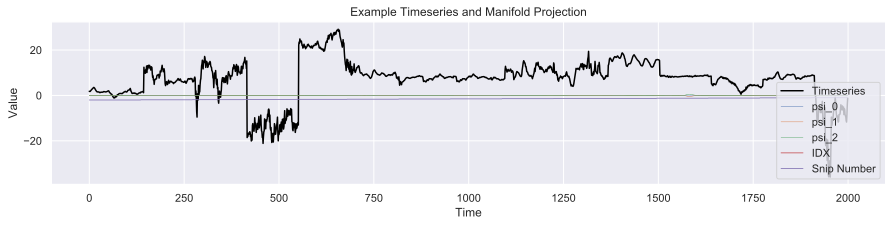

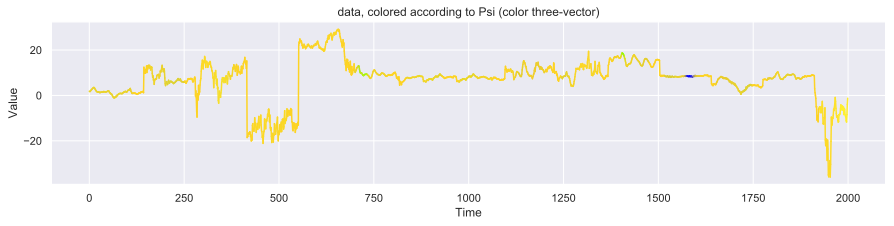


	 Program Executed for k means clustering in 5.64 seconds


In [15]:
start_time = time.time()

manifolder._clustering(numClusters=2)  # display

elapsed_time = time.time() - start_time
print('\n\t Program Executed for k means clustering in', str(np.round(elapsed_time, 2)), 'seconds')

In [16]:
from manifolder import helper as mh

In [17]:
# clustering data for k-means...

IDX = manifolder.IDX
# cluster_lens = mh.count_cluster_lengths(IDX)

# # cluster_lens is a dictionary a dictonary, where each key is the cluster number (0:6),
# # and the values are a list of cluster lengths

# mh.show_cluster_lens(cluster_lens)

In [30]:
z_breakpoint

47

In [19]:
M = mh.make_transition_matrix(IDX)
print('\n transition matrix:')
print(M)

M_z0 = mh.make_transition_matrix(IDX[manifolder.snip_number<z_breakpoint])
M_z1 = mh.make_transition_matrix(IDX[manifolder.snip_number>=z_breakpoint])

print('\n z0 transition matrix:')
print(M_z0)

print('\n z1 transition matrix:')
print(M_z1)


 transition matrix:
[[14125.     1.]
 [    1.    16.]]

 z0 transition matrix:
[[6373.    1.]
 [   1.   16.]]

 z1 transition matrix:
[[7751.]]


In [20]:
z_downsample = np.empty((0,zs[0].shape[1]+1), float)
for i in range(len(zs)):
    x = zs[i]
    x = x[0:x.shape[0]-H,:]
    x = x[::step_size]
    if i<z_breakpoint:
        x = np.append(x,np.zeros((x.shape[0],1)),1)
    else:
        x = np.append(x,np.ones((x.shape[0],1)),1)

    z_downsample = np.append(z_downsample,x,0)
    
z_downsample = np.append(z_downsample, manifolder.snip_number.reshape(len(IDX),1), 1)
z_downsample = np.append(z_downsample, IDX.reshape(len(IDX),1), 1)
    
z_downsample.shape

(14144, 18)

In [21]:
np.savetxt('astro_subset2_clustering_k=2_FTE.csv', z_downsample, delimiter=',', fmt='%f')

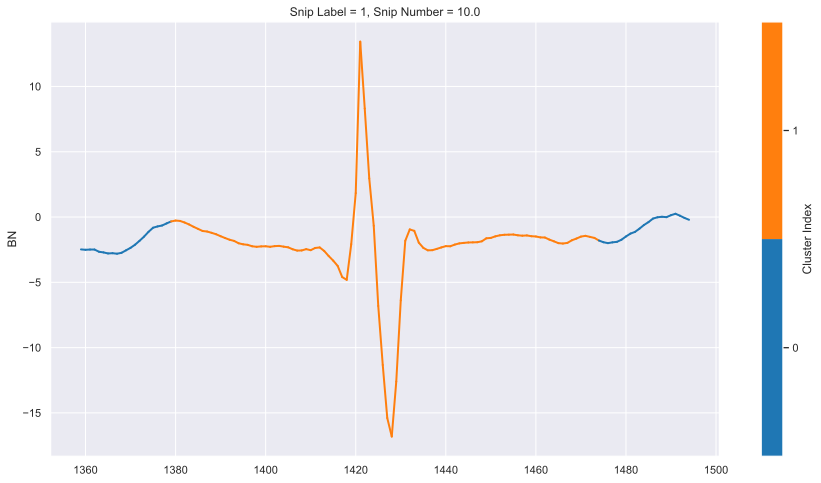

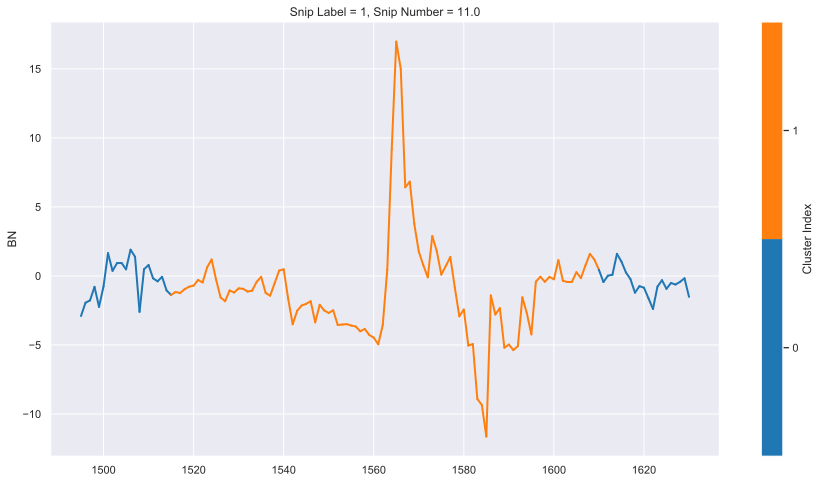

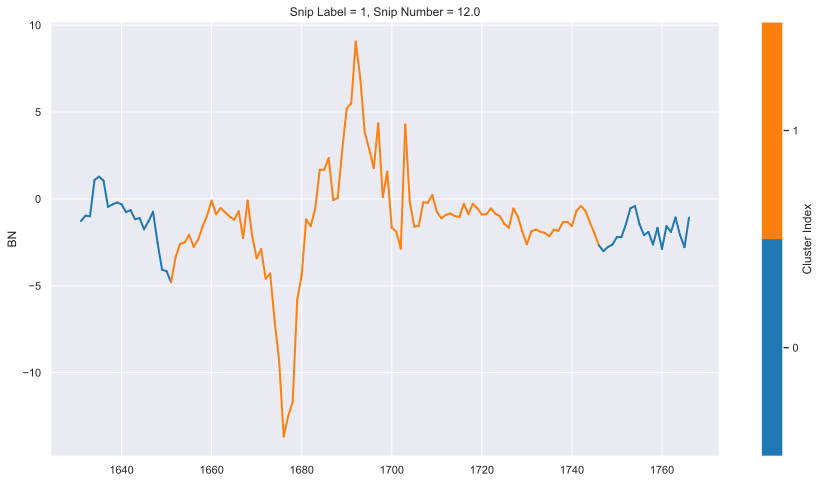

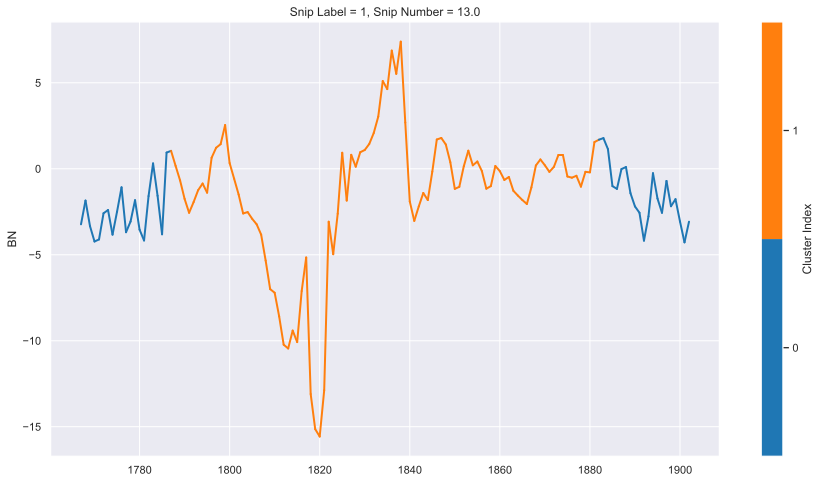

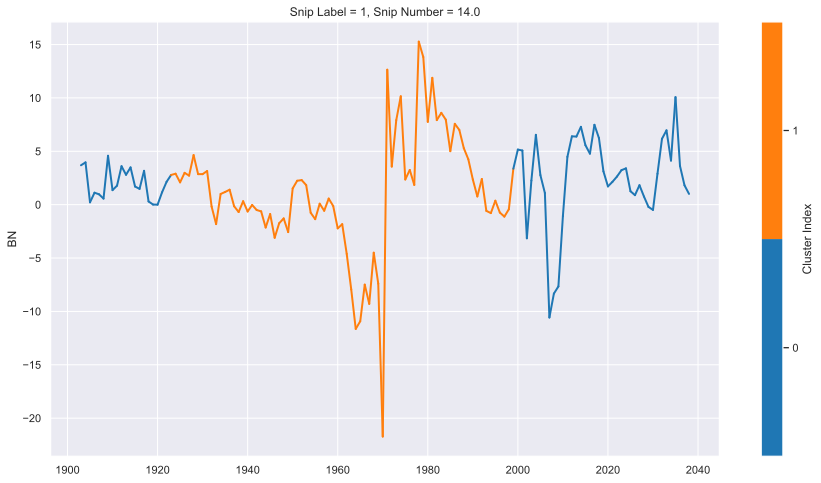

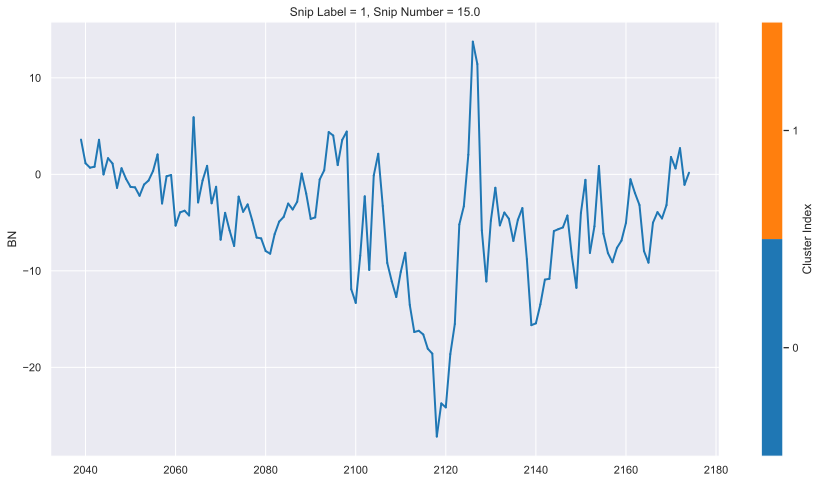

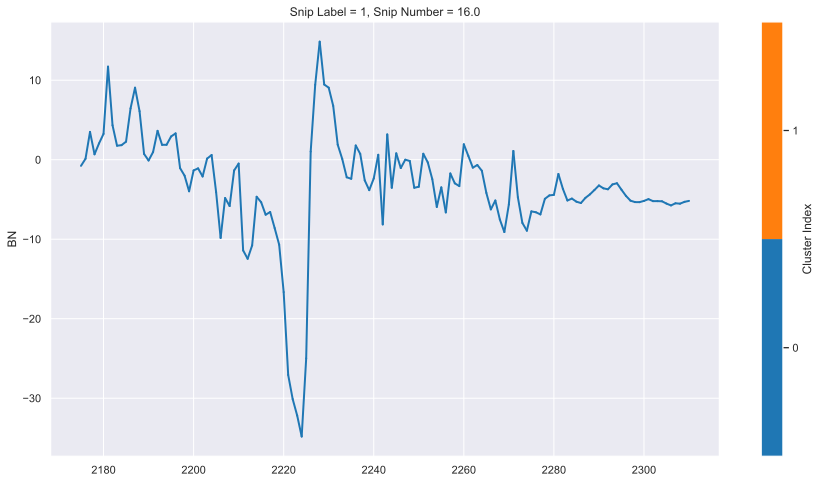

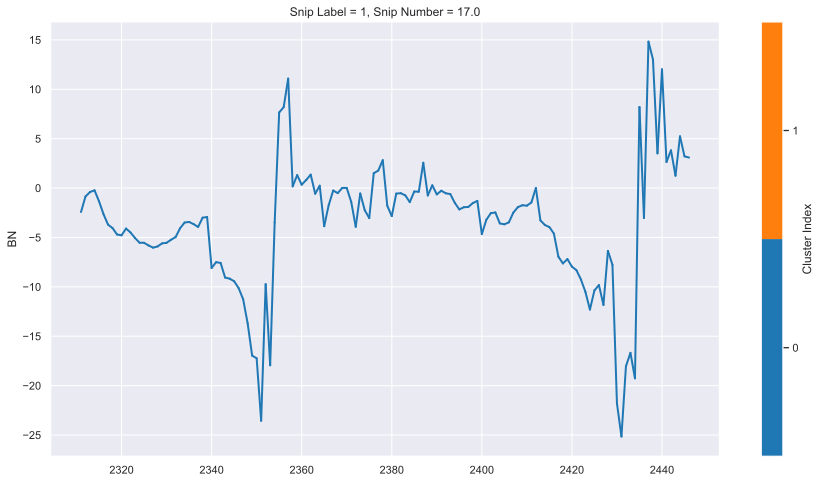

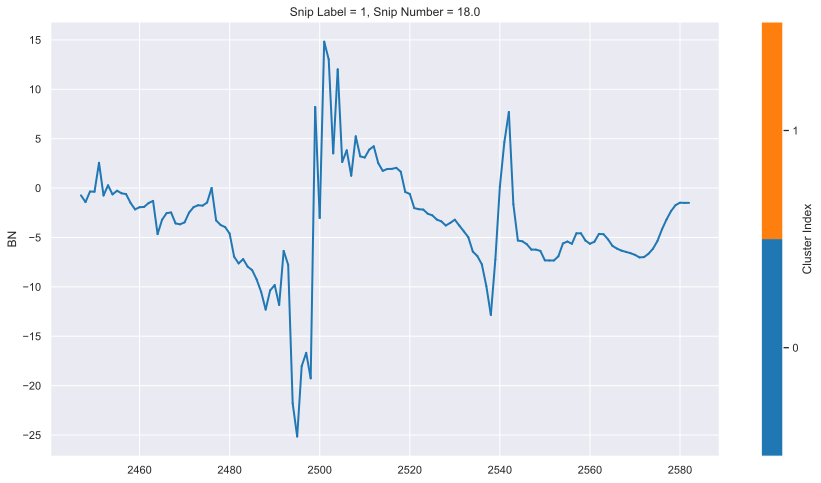

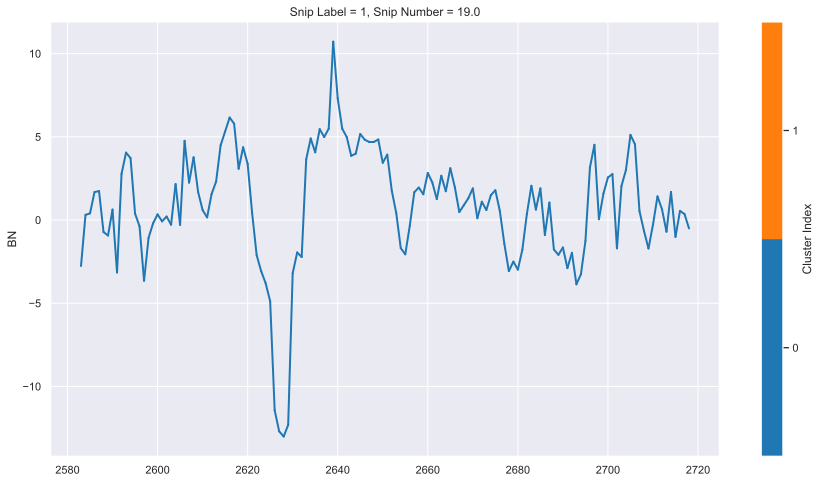

In [22]:
from manifolder.plotting import plot_clusters
import pandas as pd
df = pd.read_csv('astro_subset2_clustering_k=10_FTE.csv')
df.columns = ['Bx', 'By', 'Bz', 'BL', 'BM', 'BN',
              'Bmaд', 'Vx', 'Vy', 'Vz', 'Vmaд',
              'np', 'Tpar', 'Tper', 'Tp', 'Snip Label',
              'Snip Number', 'Cluster Index']
snip_label = 1
for snip_number in df[df['Snip Label'] == snip_label]['Snip Number'].unique():
    selected = df[(df['Snip Label'] == snip_label)  & (df['Snip Number'] == snip_number)]
    data = selected['BN']
    labels = selected['Cluster Index']
    n_clusters = 2#max(df['Cluster Index']) + 1
    fig, ax = plt.subplots(figsize=(15, 8))
    plot_clusters(
        data.index, data.values, labels,
        n_clusters=n_clusters, cbar_label='Cluster Index',
        ax=ax, lw=2
    )
    ax.set_ylabel(data.name)
    ax.set_title(f"Snip Label = {snip_label}, Snip Number = {snip_number}")

## Perform Evaluation

In [ ]:
from manifolder.plotting import plot_clusters
import pandas as pd
df = pd.read_csv('astro_subset2_clustering_k=10_FTE.csv')
df.columns = ['Bx', 'By', 'Bz', 'BL', 'BM', 'BN',
              'Bmaд', 'Vx', 'Vy', 'Vz', 'Vmaд',
              'np', 'Tpar', 'Tper', 'Tp', 'Snip Label',
              'Snip Number', 'Cluster Index']
snip_label = 1
for snip_number in df[df['Snip Label'] == snip_label]['Snip Number'].unique():
    selected = df[(df['Snip Label'] == snip_label)  & (df['Snip Number'] == snip_number)]
    data = selected['BN']
    labels = selected['Cluster Index']
    n_clusters = 2#max(df['Cluster Index']) + 1
    fig, ax = plt.subplots(figsize=(15, 8))
    x = data.index
    y = data.values